In [1]:
from skmultiflow.data import DataStream
from skmultiflow.trees import HoeffdingTreeClassifier, HoeffdingAdaptiveTreeClassifier
from skmultiflow.lazy import SAMKNNClassifier
from skmultiflow.meta import AdditiveExpertEnsembleClassifier, AdaptiveRandomForestClassifier
from skmultiflow.evaluation import EvaluatePrequential
from skmultiflow.drift_detection import ADWIN, DDM
from scipy.io.arff import loadarff
from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter, deque

from skmultiflow.metrics import ClassificationPerformanceEvaluator, WindowClassificationPerformanceEvaluator

In [ ]:
incremental = loadarff("INSECTS-incremental_balanced_norm.arff")[0][:-1]
gradual = loadarff("INSECTS-gradual_balanced_norm.arff")[0][:-1]
abrupt = loadarff("INSECTS-abrupt_balanced_norm.arff")[0][:-1]
df_incremental = pd.DataFrame(incremental)
df_gradual = pd.DataFrame(gradual)
df_abrupt = pd.DataFrame(abrupt)
#df_labels = pd.get_dummies(df_incremental['class'])
le = preprocessing.LabelEncoder()
incremental_labels = le.fit_transform(df_incremental['class'])
gradual_labels = le.fit_transform(df_gradual['class'])
abrupt_labels = le.fit_transform(df_abrupt['class'])

In [ ]:
incremental_stream = DataStream(data=df_incremental.iloc[:,:-1], y=incremental_labels)
gradual_stream = DataStream(data=df_gradual.iloc[:,:-1], y=gradual_labels)
abrupt_stream = DataStream(data=df_abrupt.iloc[:,:-1], y=abrupt_labels)

### Question 1

##### No-change classifier

In [32]:
# no-change classifier

def no_change_classifier(stream):
    stream.restart()
    print("No-change Classifier")
    pretrain_size = 1000
    n_sliding = 1000
    current_eval_measurement = WindowClassificationPerformanceEvaluator(window_size=n_sliding)
    actual_max_samples = stream.n_remaining_samples()
    global_sample_count = 0
    # pre-training
    print('Pre-training on {} sample(s).'.format(pretrain_size))
    X, y = stream.next_sample(pretrain_size)
    prediction = y[-1]
    global_sample_count += pretrain_size
    
    print('Evaluating...')
    update_count = 0
    acc = []
    while (stream.has_more_samples()):
        X, y = stream.next_sample()
        global_sample_count += 1
        # test
        current_eval_measurement.add_result(y, prediction)
        
        # train
        prediction = y
        
        # update metric
        if ((global_sample_count % n_sliding == 0) or
            (global_sample_count >= actual_max_samples) or
            (global_sample_count / n_sliding > update_count + 1)):
            acc.append(current_eval_measurement.accuracy_score())
            update_count += 1
        
    stream.restart()
    print("Finished\n")
    return acc


##### Majority class classifier

In [124]:
# Majority class classifier

def majority_class_classifier(stream):
    stream.restart()
    print("Majority Class Classifier")
    pretrain_size = 1000
    n_sliding = 1000
    current_eval_measurement = WindowClassificationPerformanceEvaluator(window_size=n_sliding)
    actual_max_samples = stream.n_remaining_samples()
    global_sample_count = 0
    d_buffer = deque(maxlen=1000)
    # pre-training
    print('Pre-training on {} sample(s).'.format(pretrain_size))
    X, y = stream.next_sample(pretrain_size)
    prediction = y[-1]
    global_sample_count += 1000
    d_buffer.extend(y.tolist())
    
    print('Evaluating...')
    update_count = 0
    acc = []
    while (stream.has_more_samples()):
        X, y = stream.next_sample()
        global_sample_count += 1
        # test
        num_values = Counter(d_buffer)
        majority_class = sorted(num_values.items(), key=lambda x: x[1], reverse=True)[0][0]
        current_eval_measurement.add_result(y, majority_class)
        
        # train
        d_buffer.append(y[0])
        
        # update metric
        if ((global_sample_count % n_sliding == 0) or
            (global_sample_count >= actual_max_samples) or
            (global_sample_count / n_sliding > update_count + 1)):
            acc.append(current_eval_measurement.accuracy_score())
            update_count += 1
            
        
    stream.restart()
    print("Finished\n")
    return acc

In [125]:
# incremental.csv
acc_no_change_incremental = no_change_classifier(incremental_stream)
acc_majority_incremental = majority_class_classifier(incremental_stream)

No-change Classifier
Pre-training on 1000 sample(s).
Evaluating...
Finished

Majority Class Classifier
Pre-training on 1000 sample(s).
Evaluating...
Finished



In [128]:
# gradual_result.csv
acc_no_change_gradual = no_change_classifier(gradual_stream)
acc_majority_gradual = majority_class_classifier(gradual_stream)

No-change Classifier
Pre-training on 1000 sample(s).
Evaluating...
Finished

Majority Class Classifier
Pre-training on 1000 sample(s).
Evaluating...
Finished



In [132]:
# abrupt_result.csv
acc_no_change_abrupt = no_change_classifier(abrupt_stream)
acc_majority_abrupt = majority_class_classifier(abrupt_stream)

No-change Classifier
Pre-training on 1000 sample(s).
Evaluating...
Finished

Majority Class Classifier
Pre-training on 1000 sample(s).
Evaluating...
Finished



### Question 2

In [71]:
ht = HoeffdingTreeClassifier()
sk = SAMKNNClassifier(n_neighbors=5, weighting='distance', max_window_size=1000,
                              stm_size_option='maxACCApprox')
hat = HoeffdingAdaptiveTreeClassifier()
# two ensemble methods
atf = AdaptiveRandomForestClassifier()
aee = AdditiveExpertEnsembleClassifier()

In [72]:
evaluator = EvaluatePrequential(n_wait=1000, pretrain_size=1000,
                                metrics=['accuracy'], output_file='incremental_result.csv')
evaluator.evaluate(stream=incremental_stream, model=[ht, sk, hat, atf, aee], model_names=['HT', 'SK', 'HAT', 'ATF', 'AEE'])

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [2050.93s]
Processed samples: 57017
Mean performance:
HT - Accuracy     : 0.5229
SK - Accuracy     : 0.5704
HAT - Accuracy     : 0.5415
ATF - Accuracy     : 0.6476
AEE - Accuracy     : 0.4744


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05),
 SAMKNNClassifier(ltm_size=0.4, max_window_size=None, min_stm_size=50,
                  n_neighbors=5, stm_size_option='maxACCApprox', use_ltm=True,
                  weighting='distance'),
 HoeffdingAdaptiveTreeClassifier(binary_split=False, bootstrap_sampling=True,
                                 grace_period=200, leaf_prediction='nba',
                                 max_byte_size=33554432,
                                 memory_estimate_period=1000000, nb_threshold=0,
                                 no_prepru

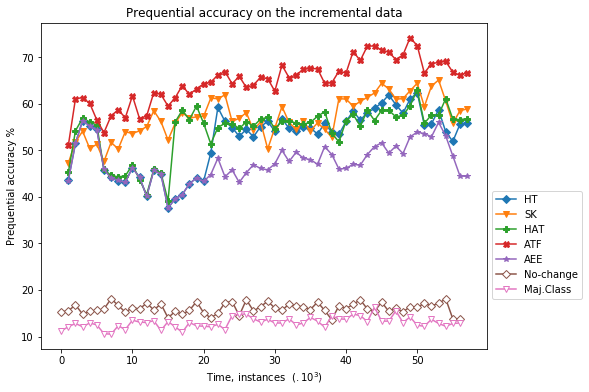

In [80]:
plt.figure(figsize=(8,6))
df_result = pd.read_csv('incremental_result.csv', header=9)
# Hoeffding Trees, SAM-KNN, Hoeffding Adaptive Trees and two ensemble models
plt.plot(df_result['current_acc_[HT]'].iloc[1:]*100, marker='D', label='HT')
plt.plot(df_result['current_acc_[SK]'].iloc[1:]*100, marker='v', label='SK')
plt.plot(df_result['current_acc_[HAT]'].iloc[1:]*100, marker='P', label='HAT')
plt.plot(df_result['current_acc_[ATF]'].iloc[1:]*100, marker='X', label='ATF')
plt.plot(df_result['current_acc_[AEE]'].iloc[1:]*100, marker='*', label='AEE')

# no-change and majority class classifier
plt.plot(np.array(acc_no_change_incremental)[1:]*100, marker='D', markerfacecolor="white", label='No-change')
plt.plot(np.array(acc_majority_incremental)[1:]*100, marker='v', markerfacecolor="white", label='Maj.Class')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.title("Prequential accuracy on the incremental data")
plt.xlabel('Time, instances  $(.10^3)$')
plt.ylabel("Prequential accuracy %")
plt.show()

In [86]:
evaluator = EvaluatePrequential(n_wait=1000, pretrain_size=1000, metrics=['accuracy'], output_file='gradual_result.csv')
evaluator.evaluate(stream=gradual_stream, model=[ht, sk, hat, atf, aee], model_names=['HT', 'SK', 'HAT', 'ATF', 'AEE'])

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [727.29s]
Processed samples: 24149
Mean performance:
HT - Accuracy     : 0.4967
SK - Accuracy     : 0.7450
HAT - Accuracy     : 0.5980
ATF - Accuracy     : 0.7710
AEE - Accuracy     : 0.4871


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05),
 SAMKNNClassifier(ltm_size=0.4, max_window_size=None, min_stm_size=50,
                  n_neighbors=5, stm_size_option='maxACCApprox', use_ltm=True,
                  weighting='distance'),
 HoeffdingAdaptiveTreeClassifier(binary_split=False, bootstrap_sampling=True,
                                 grace_period=200, leaf_prediction='nba',
                                 max_byte_size=33554432,
                                 memory_estimate_period=1000000, nb_threshold=0,
                                 no_prepru

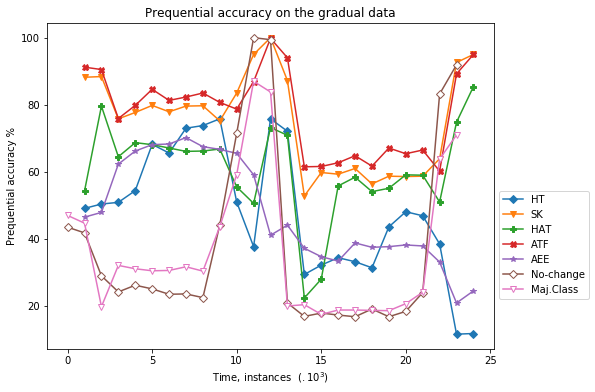

In [89]:
plt.figure(figsize=(8,6))
df_result = pd.read_csv('gradual_result.csv', header=9)
plt.plot(df_result['current_acc_[HT]'].iloc[1:,]*100, marker='D', label='HT')
plt.plot(df_result['current_acc_[SK]'].iloc[1:,]*100, marker='v', label='SK')
plt.plot(df_result['current_acc_[HAT]'].iloc[1:,]*100, marker='P', label='HAT')
plt.plot(df_result['current_acc_[ATF]'].iloc[1:,]*100, marker='X', label='ATF')
plt.plot(df_result['current_acc_[AEE]'].iloc[1:,]*100, marker='*', label='AEE')

# no-change and majority class classifier
plt.plot(np.array(acc_no_change_gradual)[1:]*100, marker='D', markerfacecolor="white", label='No-change')
plt.plot(np.array(acc_majority_gradual)[1:]*100, marker='v', markerfacecolor="white", label='Maj.Class')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.title("Prequential accuracy on the gradual data")
plt.xlabel('Time, instances  $(.10^3)$')
plt.ylabel("Prequential accuracy %")
plt.show()

In [91]:
evaluator = EvaluatePrequential(n_wait=1000, pretrain_size=1000, metrics=['accuracy'], output_file='abrupt_result.csv')
evaluator.evaluate(stream=abrupt_stream, model=[ht, sk, hat, atf, aee], model_names=['HT', 'SK', 'HAT', 'ATF', 'AEE'])

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [1707.29s]
Processed samples: 52647
Mean performance:
HT - Accuracy     : 0.4991
SK - Accuracy     : 0.6995
HAT - Accuracy     : 0.6017
ATF - Accuracy     : 0.7453
AEE - Accuracy     : 0.4595


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05),
 SAMKNNClassifier(ltm_size=0.4, max_window_size=None, min_stm_size=50,
                  n_neighbors=5, stm_size_option='maxACCApprox', use_ltm=True,
                  weighting='distance'),
 HoeffdingAdaptiveTreeClassifier(binary_split=False, bootstrap_sampling=True,
                                 grace_period=200, leaf_prediction='nba',
                                 max_byte_size=33554432,
                                 memory_estimate_period=1000000, nb_threshold=0,
                                 no_prepru

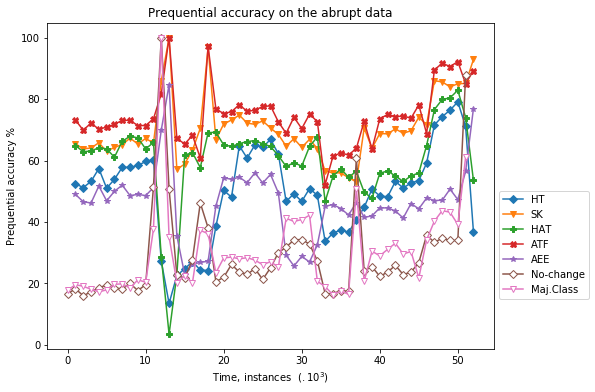

In [92]:
plt.figure(figsize=(8,6))
df_result = pd.read_csv('abrupt_result.csv', header=9)
plt.plot(df_result['current_acc_[HT]'].iloc[1:,]*100, marker='D', label='HT')
plt.plot(df_result['current_acc_[SK]'].iloc[1:,]*100, marker='v', label='SK')
plt.plot(df_result['current_acc_[HAT]'].iloc[1:,]*100, marker='P', label='HAT')
plt.plot(df_result['current_acc_[ATF]'].iloc[1:,]*100, marker='X', label='ATF')
plt.plot(df_result['current_acc_[AEE]'].iloc[1:,]*100, marker='*', label='AEE')

# no-change and majority class classifier
plt.plot(np.array(acc_no_change_abrupt)[1:]*100, marker='D', markerfacecolor="white", label='No-change')
plt.plot(np.array(acc_majority_abrupt)[1:]*100, marker='v', markerfacecolor="white", label='Maj.Class')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.title("Prequential accuracy on the abrupt data")
plt.xlabel('Time, instances  $(.10^3)$')
plt.ylabel("Prequential accuracy %")
plt.show()

### Question 4

In [6]:
# Hoeffding Tree learner with a drift detection method
def hf_drift_dectection(stream):
    ht = HoeffdingTreeClassifier() # Hoeffding Tree learner 
    drift_detector = DDM() # drift detector
    new_ht = None
    detected_steps = []
    
    stream.restart()
    print("Hoeffding Tree learner")
    pretrain_size = 1000
    n_sliding = 1000
    current_eval_measurement = WindowClassificationPerformanceEvaluator(window_size=n_sliding)
    actual_max_samples = stream.n_remaining_samples()
    global_sample_count = 0
    # pre-training
    print('Pre-training on {} sample(s).'.format(pretrain_size))
    X, y = stream.next_sample(pretrain_size)
    ht.partial_fit(X, y)
    global_sample_count += 1000
    
    print('Evaluating...')
    update_count = 0
    acc = []
    flag = False
    while (stream.has_more_samples()):
        X, y = stream.next_sample()
        global_sample_count += 1
        
        # test
        prediction = ht.predict(X)
        current_eval_measurement.add_result(y, prediction)
        drift_detector.add_element(0 if y[0] == prediction[0] else 1) # prediction is a list with single element only
        if drift_detector.detected_warning_zone() and not flag:
            print("detected warning zone", global_sample_count)
            new_ht = HoeffdingTreeClassifier()
            flag = True
        
        if drift_detector.detected_change() and flag:
            print("detected change", global_sample_count)
            detected_steps.append(global_sample_count)
            ht = new_ht
            drift_detector.reset()
            flag = False
        
        # train
        ht.partial_fit(X, y)
        
        if new_ht:
            new_ht.partial_fit(X, y)
        
        # update metric
        if ((global_sample_count % n_sliding == 0) or
            (global_sample_count >= actual_max_samples) or
            (global_sample_count / n_sliding > update_count + 1)):
            acc.append(current_eval_measurement.accuracy_score())
            update_count += 1
    stream.restart()
    print("Finished\n")
    return acc, detected_steps



Hoeffding Tree learner
Pre-training on 1000 sample(s).
Evaluating...
detected warning zone 1092
detected change 7196
detected warning zone 12282
detected change 15935
detected warning zone 21843
detected change 28384
detected warning zone 28424
detected change 55814
detected warning zone 55860
Finished



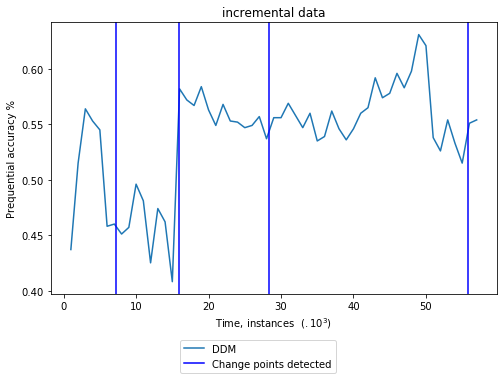

In [7]:
acc_hf_incremental, detected_steps_incremental = hf_drift_dectection(incremental_stream)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(acc_hf_incremental)), np.array(acc_hf_incremental)[1:], label = 'DDM')
detected_steps_incremental2 = np.array(detected_steps_incremental)/1000
plt.axvline(x = detected_steps_incremental2[0], color = 'b', label = 'Change points detected')
for i in detected_steps_incremental2[1:]:
    plt.axvline(x = i, color = 'b')
plt.legend(bbox_to_anchor=(0.65, -0.15))
plt.title('incremental data')
plt.xlabel('Time, instances  $(.10^3)$')
plt.ylabel("Prequential accuracy %")
plt.show()

Hoeffding Tree learner
Pre-training on 1000 sample(s).
Evaluating...
detected warning zone 1068
detected change 14113
detected warning zone 22911
detected change 23119
detected warning zone 23187
Finished



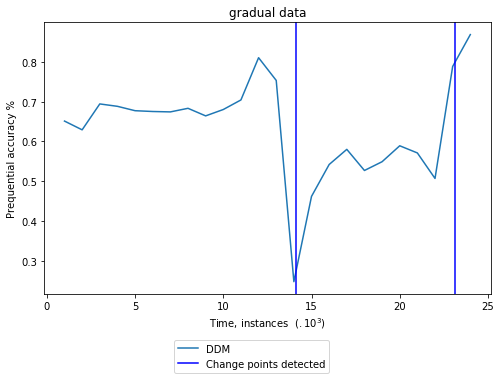

In [109]:
acc_hf_gradual, detected_steps_gradual = hf_drift_dectection(gradual_stream)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(acc_hf_gradual)), acc_hf_gradual[1:], label = 'DDM')
detected_steps_gradual2 = np.array(detected_steps_gradual)/1000
plt.axvline(x = detected_steps_gradual2[0], color = 'b', label = 'Change points detected')
for i in detected_steps_gradual2[1:]:
    plt.axvline(x = i, color = 'b')
plt.legend(bbox_to_anchor=(0.65, -0.15))
plt.title('gradual data')
plt.xlabel('Time, instances  $(.10^3)$')
plt.ylabel("Prequential accuracy %")
plt.show()

Hoeffding Tree learner
Pre-training on 1000 sample(s).
Evaluating...
detected warning zone 1375
detected change 1612
detected warning zone 2680
detected change 14543
detected warning zone 19841
detected change 20679
detected warning zone 21368
detected change 28085
detected warning zone 28640
detected change 33334
detected warning zone 33441
detected change 39343
detected warning zone 39421
detected change 39505
detected warning zone 39541
Finished



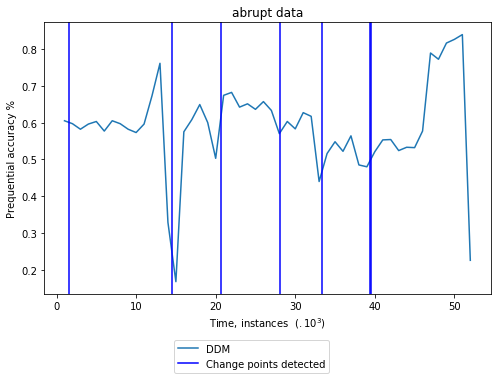

In [112]:
acc_hf_abrupt, detected_steps_abrupt = hf_drift_dectection(abrupt_stream)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(acc_hf_abrupt)), acc_hf_abrupt[1:], label = 'DDM')
detected_steps_abrupt2 = np.array(detected_steps_abrupt)/1000
plt.axvline(x = detected_steps_abrupt2[0], color = 'b', label = 'Change points detected')
for i in detected_steps_abrupt2[1:]:
    plt.axvline(x = i, color = 'b')
plt.legend(bbox_to_anchor=(0.65, -0.15))
plt.title('abrupt data')
plt.xlabel('Time, instances  $(.10^3)$')
plt.ylabel("Prequential accuracy %")
plt.show()